## **Download Packages**

In [ ]:
!pip install patchify

## **Loading Libraries**

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, metrics
import tensorflow as tf
from tensorflow.keras.layers import Layer, Multiply,GlobalAveragePooling1D,MultiHeadAttention,Embedding,Lambda,Dense,Flatten,Conv2D,Dropout, Conv2DTranspose, MaxPooling2D, Input, Activation, Concatenate, UpSampling2D, Resizing,Reshape,Add,LayerNormalization,BatchNormalization
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from tensorflow.keras.saving import register_keras_serializable
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.colors as colors
import pickle
from tensorflow.keras.models import load_model
from sklearn.metrics import precision_score, recall_score, f1_score, jaccard_score
import tensorflow_hub as hub
from tensorflow.keras.utils import to_categorical
#from patchify import patchify
from tensorflow.keras import backend as K
from tensorflow.keras.regularizers import l2
from math import log2
import albumentations as A
import time

/opt/conda/lib/python3.10/site-packages/albumentations/__init__.py:13: UserWarning: A new version of Albumentations is available: 2.0.4 (you have 1.4.17). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


## **Load Data**

In [2]:
path = '/kaggle/input/satellite-images-of-water-bodies/Water Bodies Dataset'

In [3]:
data = tf.keras.utils.image_dataset_from_directory(directory = path, image_size = (128, 128), batch_size = 6000, shuffle = False)

Found 5682 files belonging to 2 classes.


In [4]:
for images, masks in data:
    X = images.numpy().astype("uint8")
    y = masks.numpy().astype("uint8")

print(X.shape, y.shape)

(5682, 128, 128, 3) (5682,)


In [5]:
images = X[y == 0]
masks = X[y == 1]

print(images.shape, masks.shape)

(2841, 128, 128, 3) (2841, 128, 128, 3)


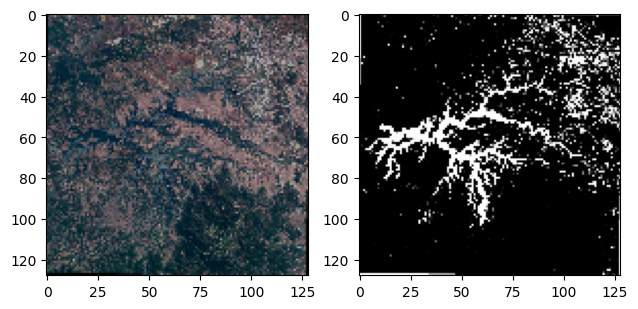

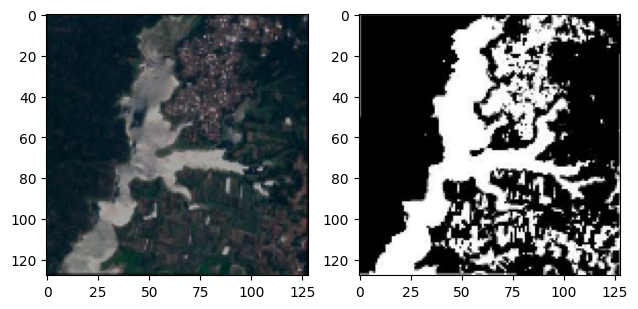

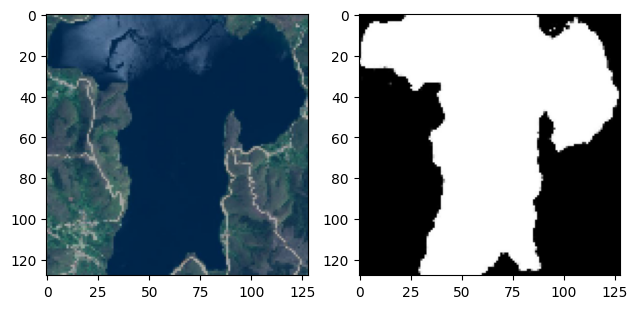

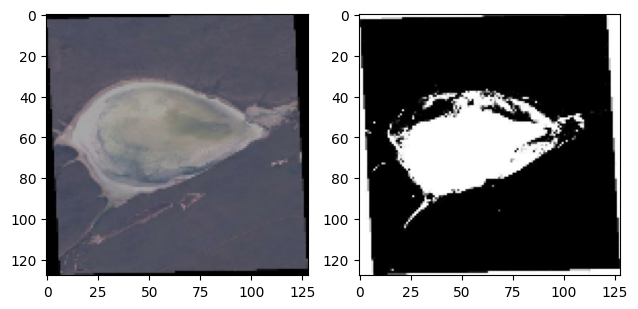

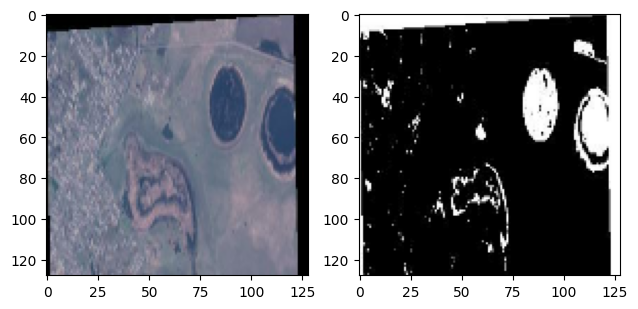

In [6]:
for i in range(5):
    plt.subplot(1, 2, 1)
    plt.imshow(images[i])

    plt.subplot(1, 2, 2)
    plt.imshow(masks[i])

    plt.tight_layout()
    plt.show()

## **Split Data into Train and Test**

In [7]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(images, masks, test_size = 0.2, random_state = 3)

print(X_train.shape, X_test.shape)

(2272, 128, 128, 3) (569, 128, 128, 3)


## **Mask to single Channel**

In [8]:
# Convert masks to single channel (binary)
y_train = (y_train[..., 0] > 0).astype("uint8")  # Assuming the first channel represents the mask
y_test = (y_test[..., 0] > 0).astype("uint8")

# Reshape your target arrays to match the model's output shape
y_train = y_train.reshape((-1, 128, 128, 1))
y_test = y_test.reshape((-1, 128, 128, 1))

print(y_train.shape, y_test.shape)

(2272, 128, 128, 1) (569, 128, 128, 1)


In [9]:
transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.RandomBrightnessContrast(p=0.2),
    A.ElasticTransform(p=0.2),
    A.GridDistortion(p=0.2),
])

def augment_image(img, mask):
    augmented = transform(image=img, mask=mask)
    return augmented['image'], augmented['mask']

X_aug, y_aug = zip(*[augment_image(img, mask) for img, mask in zip(X_train, y_train)])

X_train = np.concatenate((X_train, np.array(X_aug)), axis=0)
y_train = np.concatenate((y_train, np.array(y_aug)), axis=0)

In [10]:
print(f"X_train: {X_train.shape} and y_train: {y_train.shape}")

X_train: (4544, 128, 128, 3) and y_train: (4544, 128, 128, 1)


## **Function to plot metrics**

In [31]:
def plot_training_history(history, title):
    # Check if `history` is a dictionary and adapt
    if isinstance(history, dict):
        acc = history['accuracy']
        val_acc = history['val_accuracy']
        loss = history['loss']
        val_loss = history['val_loss']
    else:
        acc = history.history['accuracy']
        val_acc = history.history['val_accuracy']
        loss = history.history['loss']
        val_loss = history.history['val_loss']

    # Plot Accuracy
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(acc, label='Train Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.title(f'{title} - Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(loss, label='Train Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.title(f'{title} - Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt


## **Early Stopping**

In [12]:
# Early Stopping
c1 = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 10, restore_best_weights = True)

## **Calculate IOU**

In [26]:
def calculate_IOU_per_image(y_true, y_pred, threshold=0.5):
    # Binarize predictions for each image
    iou_list = []
    for i in range(y_true.shape[0]):
        y_true_img = (y_true[i] > threshold).astype(int).flatten()
        y_pred_img = (y_pred[i] > threshold).astype(int).flatten()
        iou = jaccard_score(y_true_img, y_pred_img)
        iou_list.append(iou)
    return np.mean(iou_list)

def Testing_IoU(model, X_test, y_test):
    y_pred_prob = model.predict(X_test)
    return calculate_IOU_per_image(y_test, y_pred_prob)

def Training_IoU(model, X_train, y_train):
    y_pred_prob = model.predict(X_train)
    return calculate_IOU_per_image(y_train, y_pred_prob)


In [27]:
def Testing_F1(model, X_test, y_test):
    # Predict probabilities
    y_pred_prob = model.predict(X_test)
    # Threshold predictions to get binary masks
    y_pred = (y_pred_prob > 0.5).astype(int)
    # Flatten the arrays
    y_true_flat = y_test.flatten()
    y_pred_flat = y_pred.flatten()
    # Ensure binary ground truth
    y_true_flat = (y_true_flat > 0.5).astype(int)
    return f1_score(y_true_flat, y_pred_flat)

def Training_F1(model, X_train, y_train):
    y_pred_prob = model.predict(X_train)
    y_pred = (y_pred_prob > 0.5).astype(int)
    y_true_flat = y_train.flatten()
    y_pred_flat = y_pred.flatten()
    y_true_flat = (y_true_flat > 0.5).astype(int)
    return f1_score(y_true_flat, y_pred_flat)


In [28]:
def evaluation(model, model_name):
    #results_train = model.evaluate(X_train, y_train, verbose=0)
    #results_test = model.evaluate(X_test, y_test, verbose=0)

    #train_loss, train_accuracy = results_train[0], results_train[1]
    #test_loss, test_accuracy = results_test[0], results_test[1]

    train_loss, train_accuracy = model.evaluate(X_train, y_train, verbose=0)
    test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)

    data = {
    'Algorithm': [model_name[0], model_name[1]],
    'Accuracy': [f"{train_accuracy:.3f}", f"{test_accuracy:.3f}"],
    'Loss': [f"{train_loss:.3f}", f"{test_loss:.3f}"],
    'mIOU': [f"{Training_IoU(model, X_train, y_train):.3f}", f"{Testing_IoU(model, X_test, y_test):.3f}"],
    'F1 Score': [f"{Training_F1(model, X_train, y_train):.3f}", f"{Testing_F1(model, X_test, y_test):.3f}"]
    }

    df = pd.DataFrame(data)

    return df

## **Plot trained images**

In [15]:
def plot_images(X_test, y_test, model_mask, selected_indices):
    for i in selected_indices:
        plt.figure(figsize=(15,5))

        # orignal image
        plt.subplot(1,4,1)
        plt.imshow(X_test[i].squeeze())
        plt.title("Orignal Image")
        plt.axis("off")

        # Orignal Mask
        plt.subplot(1,4,2)
        plt.imshow(y_test[i].squeeze(), cmap='viridis') # viridis gray
        plt.title('Orignal Mask')
        plt.axis("off")

        # Model Mask
        plt.subplot(1,4,3)
        plt.imshow(model_mask[i].squeeze(), cmap='viridis')
        plt.title('Model Mask')
        plt.axis("off")
    plt.show()

### **Learning Rate Scheduler**

In [16]:
def lr_scheduler(monitor, factor, patience, min_lr):
    lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor=monitor, factor=factor, patience=patience, min_lr=min_lr, verbose=1
    )
    return lr

# **UNET**

### **Encoder and Decoder**

In [17]:
def encoder_block(inputs, num_filters):
    x = tf.keras.layers.Conv2D(num_filters, 3, padding = 'same', kernel_initializer = "he_uniform")(inputs)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding = 'same', kernel_initializer = "he_uniform")(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.MaxPool2D(pool_size = (2, 2), strides = 2)(x)
    return x

def decoder_block(inputs, skip_features, num_filters):
    x = tf.keras.layers.Conv2DTranspose(num_filters, (2, 2), strides = 2, padding = 'same')(inputs)
    skip_features = tf.keras.layers.Resizing(x.shape[1], x.shape[2])(skip_features)
    x = tf.keras.layers.Concatenate()([x, skip_features])
    x = tf.keras.layers.Conv2D(num_filters, 3, padding = 'same', kernel_initializer = "he_uniform")(x)
    x = tf.keras.layers.Activation('relu')(x)
    x = tf.keras.layers.Conv2D(num_filters, 3, padding = 'same', kernel_initializer = "he_uniform")(x)
    x = tf.keras.layers.Activation('relu')(x)
    return x

### **Model Architecture**

In [18]:
def unet_model(input_shape, num_classes):
    inputs = tf.keras.layers.Input(shape = input_shape)

    s1 = encoder_block(inputs, 32)
    s2 = encoder_block(s1, 64)
    s3 = encoder_block(s2, 128)
    s4 = encoder_block(s3, 256)
    print(s4.shape)
    b1 = tf.keras.layers.Conv2D(filters = 512, kernel_size = (3, 3), padding = "same")(s4) # kernel_initializer = "he_uniform"
    b1 = tf.keras.layers.Activation('relu')(b1)
    b1 = tf.keras.layers.Conv2D(filters = 512, kernel_size = (3, 3), padding = "same")(b1) #  kernel_initializer = "he_uniform"
    b1 = tf.keras.layers.Activation('relu')(b1)

    s5 = decoder_block(b1, s4, 256)
    s6 = decoder_block(s5, s3, 128)
    s7 = decoder_block(s6, s2, 64)
    s8 = decoder_block(s7, s1, 32)

    outputs = tf.keras.layers.Conv2D(filters = num_classes, kernel_size = (3, 3), padding = "same", activation = "sigmoid")(s8)

    model = tf.keras.models.Model(inputs = [inputs], outputs = [outputs], name = 'U-Net')
    return model

In [19]:
unet_model = unet_model(input_shape = (128, 128, 3), num_classes = 1)
#unet_model.summary()

(None, 8, 8, 256)


In [21]:
unet_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), # clipvalue=0.5
    loss= "binary_crossentropy",
    metrics=["accuracy"]  # Include both IoU and Dice metrics
)

In [22]:
lr_scheduler = lr_scheduler(monitor='val_loss', factor=0.3, patience=5, min_lr=1e-6)

In [24]:
history = unet_model.fit(
    X_train,
    y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    #batch_size = 20,
    callbacks = [lr_scheduler, c1]
)

Epoch 1/100


I0000 00:00:1740744978.751462     101 service.cc:145] XLA service 0x7ba6f0009e70 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1740744978.751531     101 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0


  2/142 ━━━━━━━━━━━━━━━━━━━━ 11s 83ms/step - accuracy: 0.4943 - loss: 33.5521 

I0000 00:00:1740744990.358012     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


142/142 ━━━━━━━━━━━━━━━━━━━━ 32s 109ms/step - accuracy: 0.6380 - loss: 5.9670 - val_accuracy: 0.6585 - val_loss: 0.6876 - learning_rate: 0.0010
Epoch 2/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - accuracy: 0.7015 - loss: 0.6243 - val_accuracy: 0.7180 - val_loss: 0.5749 - learning_rate: 0.0010
Epoch 3/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - accuracy: 0.7269 - loss: 0.5642 - val_accuracy: 0.7504 - val_loss: 0.5294 - learning_rate: 0.0010
Epoch 4/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - accuracy: 0.7460 - loss: 0.5339 - val_accuracy: 0.7560 - val_loss: 0.5374 - learning_rate: 0.0010
Epoch 5/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - accuracy: 0.7502 - loss: 0.5292 - val_accuracy: 0.7635 - val_loss: 0.5093 - learning_rate: 0.0010
Epoch 6/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 12s 81ms/step - accuracy: 0.7523 - loss: 0.5256 - val_accuracy: 0.7634 - val_loss: 0.5041 - learning_rate: 0.0010
Epoch 7/100
142/142 ━━━━━━━━━━━━━━━━━━━━ 12s 82ms/step - accuracy: 0.7553 - loss:

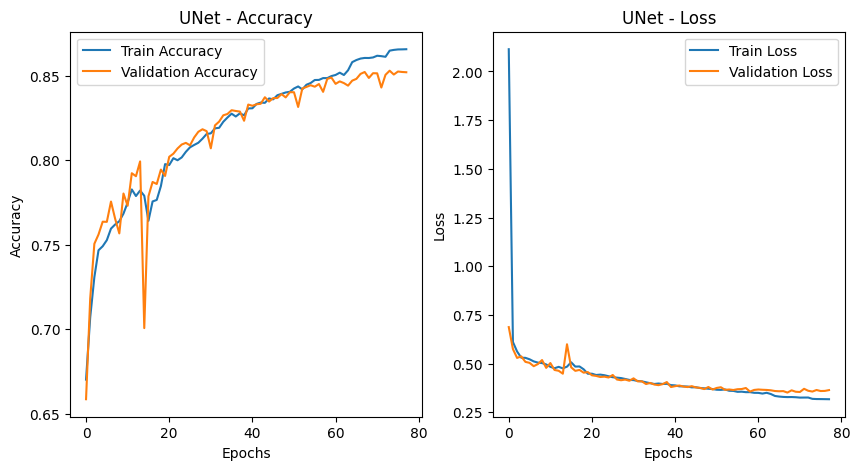

In [32]:
plot_training_history(history, "UNet")

In [33]:
unet_matrix = evaluation(unet_model, ['Unet (Training)', 'Unet (Validation)'])
print(unet_matrix)

142/142 ━━━━━━━━━━━━━━━━━━━━ 4s 24ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 69ms/step
142/142 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
           Algorithm Accuracy   Loss   mIOU F1 Score
0    Unet (Training)    0.862  0.325  0.660    0.825
1  Unet (Validation)    0.852  0.352  0.632    0.808


In [37]:
unet_model.save('UNET.keras')

In [231]:
#unet_trained_model = load_model("/kaggle/input/unet/tensorflow2/default/1/UNET.keras")

In [232]:
with open('/kaggle/input/unet/tensorflow2/default/1/training_history.pkl', 'rb') as file:
    history = pickle.load(file)

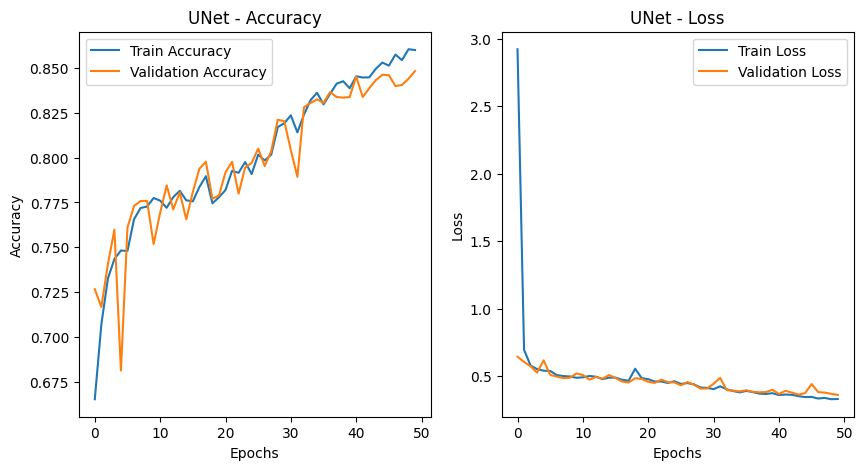

In [233]:
plot_training_history(history, "UNet")

In [234]:
unet_trained_history = trained_history('/kaggle/input/unet/tensorflow2/default/1/training_history.pkl',unet_trained_model, ['U-Net (Training)', 'U-Net (Validation)'], X_train, y_train, X_test, y_test)
print(unet_trained_history)

71/71 ━━━━━━━━━━━━━━━━━━━━ 4s 52ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step
            Algorithm  Accuracy      Loss      mIOU
0    U-Net (Training)  0.859886  0.329369  0.662199
1  U-Net (Validation)  0.848209  0.359503  0.626758


In [34]:
unet_masks = unet_model.predict(X_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


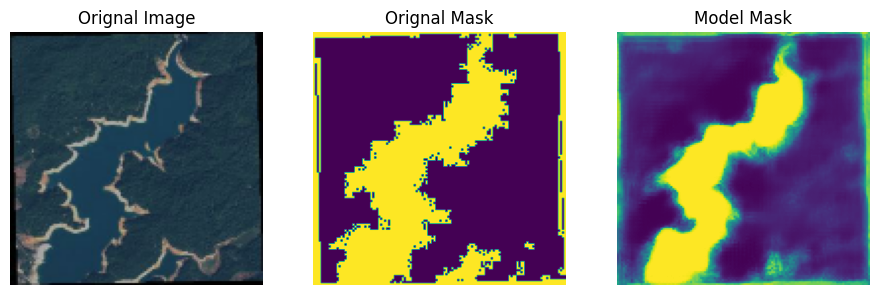

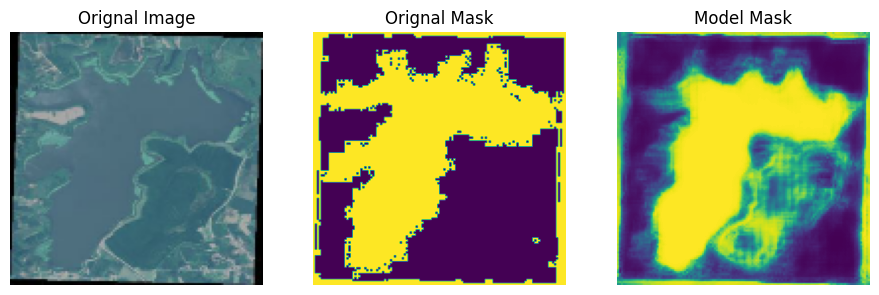

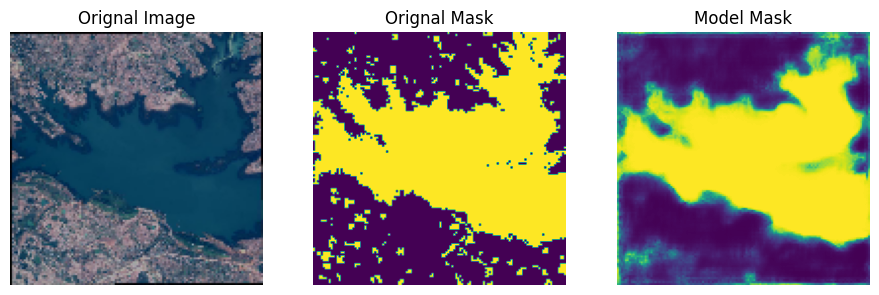

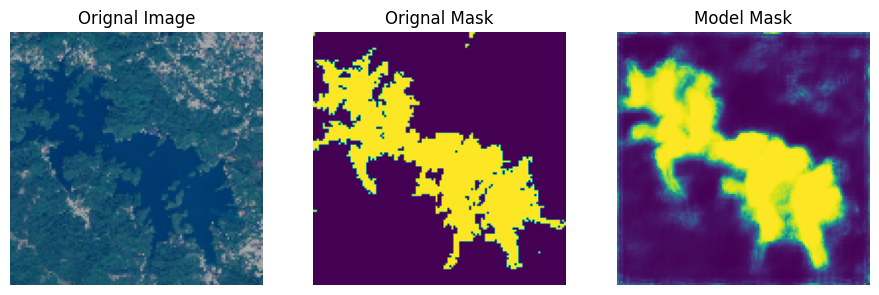

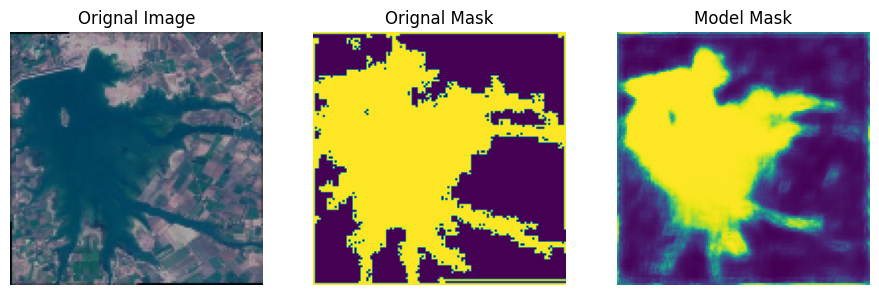

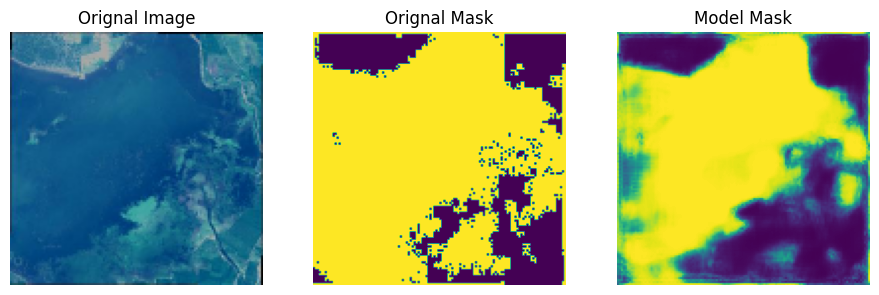

In [35]:
plot_images(X_test, y_test, unet_masks, selected_indices = [1, 4, 22, 25, 46, 95]) #31

# **UNET Attention**

### **Convolution Block helper function**

In [ ]:
def conv_block(x, num_filters):
    x = Conv2D(num_filters, (3, 3), padding='same', kernel_initializer="he_uniform")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(num_filters, (3, 3), padding='same', kernel_initializer="he_uniform")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    return x

### **Encoder**

In [ ]:
def encoder_block(x, num_filters):
    x = conv_block(x, num_filters)
    p = MaxPooling2D((2, 2))(x)
    return x, p

### **Attention Block**

In [ ]:
def align_shapes(Wg, Wx):
    """Aligns Wx to the shape of Wg if necessary."""
    shape_Wg = K.int_shape(Wg)
    shape_Wx = K.int_shape(Wx)

    # Check if Wx needs to be upsampled
    if shape_Wg[1] != shape_Wx[1] or shape_Wg[2] != shape_Wx[2]:
        # Compute upsampling factors
        upsample_h = shape_Wg[1] // shape_Wx[1]
        upsample_w = shape_Wg[2] // shape_Wx[2]

        # Apply upsampling to Wx
        Wx = UpSampling2D(size=(upsample_h, upsample_w))(Wx)

    return Wx

In [ ]:
def attention_block(g, x, num_filters):
  shape_g = K.int_shape(g)
  shape_x = K.int_shape(x)

  Wg = Conv2D(num_filters, (1, 1), strides=1, padding='same')(g)
  Wg = BatchNormalization()(Wg)

  Wx = Conv2D(num_filters, (1, 1), strides=2, padding='same')(x)
  Wx = BatchNormalization()(Wx)

  #Wx = align_shapes(Wg, Wx)

  print(f"Wg: {Wg.shape}")
  print(f"Wx: {Wx.shape}")
  concat_xg = Add()([Wg, Wx])
  # relu_act_xg = Activation('relu')(Wg + Wx)
  relu_act_xg = Activation('relu')(concat_xg)
  psi = Conv2D(1, (1, 1), padding='same')(relu_act_xg)
  sig_act_xg = Activation('sigmoid')(psi)
  shape_sig = K.int_shape(sig_act_xg)
    
  print(f"Before Upsample Attention {sig_act_xg.shape}, {x.shape}")
    
  upsample = UpSampling2D(size = (shape_x[1] // shape_sig[1], shape_x[2] // shape_sig[2]))(sig_act_xg)
  out = Multiply()([upsample, x])
  print(f"Before Output Concatenation upsample:{upsample.shape}, X:{x.shape}")
  print(f"Output of Attention block of UNET {out.shape}")

  return out


### **Decoder**

In [ ]:
# Here g is the decoder output or previous layer and x is the skip connection which conv output of encode before max pooling
def attention_decoder(g, x, num_filters):
  x = attention_block(g, x, num_filters)
  #g = UpSampling2D(interpolation="bilinear")(g)
  g = Conv2DTranspose(num_filters, kernel_size=(2, 2), strides=2, padding='same')(g)
  print(f"Decoder attention after upsample: g:{g.shape} and x:{x.shape}")
  g = Concatenate()([g, x])
  g = conv_block(g, num_filters)
  return g

### **Model Architecture**

In [ ]:
def attention_unet(input_shape, num_classes):
    inputs = Input(shape=input_shape) 

    # Encoder
    s1, p1 = encoder_block(inputs, 32)
    s2, p2 = encoder_block(p1, 64)
    s3, p3 = encoder_block(p2, 128)
    s4, p3 = encoder_block(p3, 256)

    # Bottleneck
    b1 = conv_block(p3, 512)
    print(f"b: {b1.shape} and s4:{s4.shape}")
    # Decoder
    d1 = attention_decoder(b1, s4, 256)
    d2 = attention_decoder(d1, s3, 128)
    d3 = attention_decoder(d2, s2, 64)
    d4 = attention_decoder(d3, s1, 32)
    
    output = Conv2D(num_classes, (1, 1), activation='sigmoid')(d4)

    model = Model(inputs, output, name='Attention_U-Net')
    return model

In [ ]:
unet_att = attention_unet(input_shape = (128, 128, 3), num_classes = 1)
#unet_att.summary()

In [ ]:
unet_att.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), 
    loss = keras.losses.BinaryCrossentropy(), 
    metrics = ["accuracy"]
)

In [ ]:
unet_att_history = unet_att.fit(X_train, y_train,  epochs=100, validation_data=(X_test, y_test), batch_size=12, callbacks = [lr_scheduler, c1])

In [236]:
with open('/kaggle/input/unet-attention/tensorflow2/default/1/training_unet_att_history.pkl', 'rb') as file:
    unet_att_history = pickle.load(file)

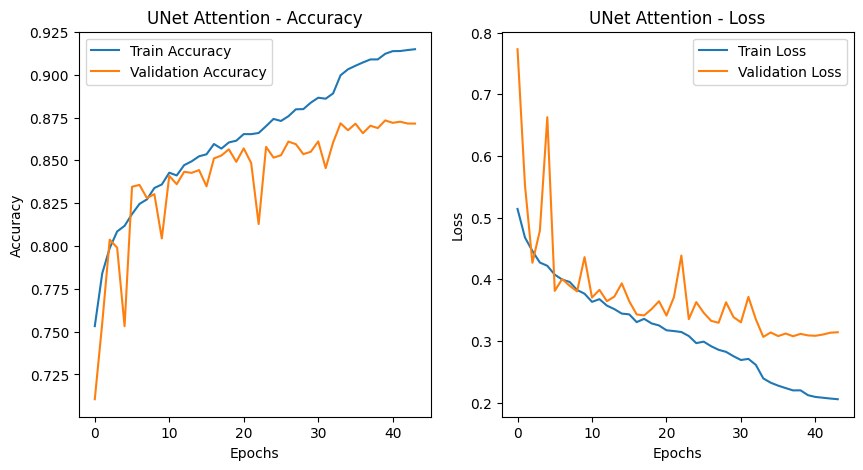

In [237]:
plot_training_history(unet_att_history, "UNet Attention")

In [ ]:
#unet_att.save("unet_att.keras")

In [ ]:
#with open('/kaggle/working/training_unet_att_history.pkl', 'wb') as file:
 #   pickle.dump(unet_att_history.history, file)

In [ ]:
#!mv unet_att.keras /kaggle/working/

In [238]:
unet_att_trained_model = load_model("/kaggle/input/unet-attention/tensorflow2/default/1/unet_att.keras")

In [239]:
unet_att_trained_history = trained_history('/kaggle/input/unet-attention/tensorflow2/default/1/training_unet_att_history.pkl',unet_att_trained_model, ['U-Net Attention (Training)', 'U-Net Attention (Validation)'], X_train, y_train, X_test, y_test)
print(unet_att_trained_history)

71/71 ━━━━━━━━━━━━━━━━━━━━ 6s 61ms/step
18/18 ━━━━━━━━━━━━━━━━━━━━ 3s 157ms/step
                      Algorithm  Accuracy      Loss      mIOU
0    U-Net Attention (Training)  0.914932  0.205448  0.747117
1  U-Net Attention (Validation)  0.871487  0.314036  0.677502


In [240]:
#unet_att_masks = unet_att.predict(X_test)
unet_att_masks = unet_att_trained_model.predict(X_test)

18/18 ━━━━━━━━━━━━━━━━━━━━ 1s 63ms/step


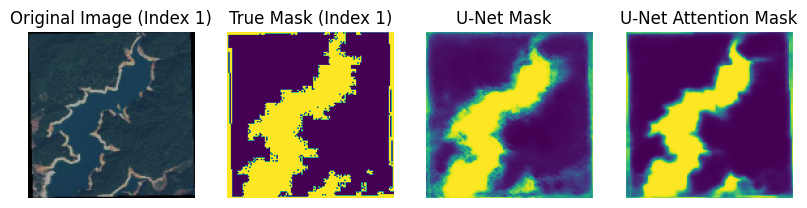

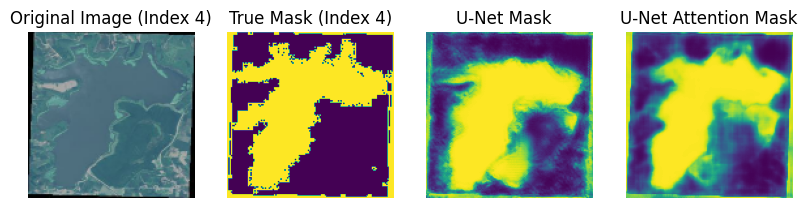

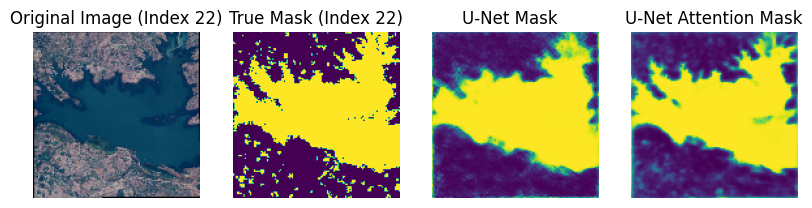

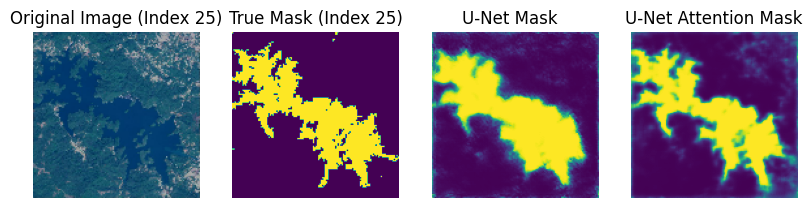

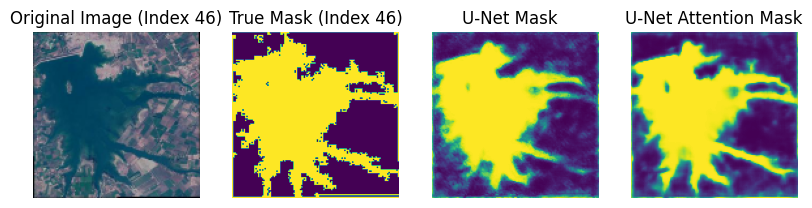

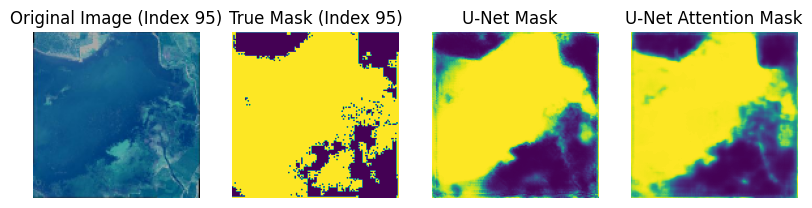

In [241]:
plot_images(X_test, y_test, unet_masks, unet_att_masks,  selected_indices = [1, 4, 22, 25, 46, 95]) # 31